
## ECOPs AFRICA OCEAN COLOUR TRAINING

### M2-L1: Data manipulation and analysis
<span style="color:brown; font-size:1.2em;font-style:italic">Part 1.3 create animations</span>
<hr style="border:2px solid rgb(30,70,125)"> </hr>


<span style="font-size:1.1em;">Eligio Maure (maure@npec.or.jp)</span>

***
**Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***

# Table of contents
- [1. Purpose](#1.-Purpose)
- [2. Library import](#2.-Library-import)
- [3. Data retrieval](#3.-Data-retrieval)
- [4. Animation helpers](#4.-Animation-helpers)
- [5. Create the animation](#5.-Create-the-animation)
- [6. Resources](#6.-Resources)
***

# 1. Purpose
[Return to the "Table of contents"](#Table-of-contents)

In this exercise you will learn to
- create animation of a series of images
- save the animations as HTML or mp4 file

***

# 2. Library import   

[Return to the "Table of contents"](#Table-of-contents)

Start by importing require modules for this activity   
If a module throws a `ModuleNotFoundError` try installing it with the command  
- `!conda install --channel "conda-forge" module` or with  
- `!pip install module`  

If you have a requirement file containing the names of the modules you want to install, use
- `!pip install -r requirements.txt`

Remove `!` if you run the command directly in your terminal or command prompt.   
For this exercise we created a Python environment using the `environment.yml` file which contains the required module.   
You can also add additional modules to the list.

---

In [1]:
import re
from datetime import datetime

# Data manipulation
import numpy as np

# Library import
from netCDF4 import Dataset

# System
import sys
from pathlib import Path

# Visualization
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, animation
from IPython.display import HTML

from cartopy import crs as ccrs, feature as cfeature

# %matplotlib inline
%matplotlib notebook

Matplotlib comes with defaults parameters used for plotting and visualization.   
For example, during instantiation of figures in Matplotlib, often we pass `figsize` parameter to `plt.figure`. <br>
Matplotlib can also be customized to override the default values using rc (runtime configuration) settings.
***

In [2]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (7, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['savefig.facecolor'] = '0.8'
plt.rcParams['figure.constrained_layout.use'] = True

- **Local modules**  

Include a local library (scripts) with custom fuctions.  

We use the `sys` module to append a directory to the list of known paths for interpreter to search.  
This allow us to import the custom functions or modules not in the search directories.

We also use the `Path` library to help us get the name of the current working directory.

---

In [3]:
# appending a path
cwd = Path.cwd()
sys.path.append(str(cwd.parent))

import octutils as util

# 3. Data retrieval

[Return to the "Table of contents"](#Table-of-contents)

We retrieve SST or CHL for the Mozambique Channel

We use the following parameters for our animation <br>
- Time Period: 1-year period (monthly images), beginning 1 Jan 2021
- Sensor: MODIS-Aqua
- Area of Interest: region bounded by Lat: 10-30S, and Lon: 30-50E  <br>

I ordered the data using the Level-3 Browser. So, I will use a manifest download and then unzip the files to get the images in the `data` folder.

In [4]:
manifest = cwd.joinpath('data', 'http_manifest.txt')

In [5]:
# # download using manifest file
# files = util.getfile(sensor='modisa', manifest=manifest)
# print('\n'.join(f'{i+1:02}: {f.name}' for i, f in enumerate(files)))

In [6]:
# Since the downloaded file is tar file, manually unzip and load the images again
files = list(cwd.joinpath('data').glob("A*.L3m_MO_CHL.x_chlor_a.nc"))
print('\n'.join(f'{i+1:02}: {f.name}' for i, f in enumerate(files)))

01: A20210012021031.L3m_MO_CHL.x_chlor_a.nc
02: A20210322021059.L3m_MO_CHL.x_chlor_a.nc
03: A20210602021090.L3m_MO_CHL.x_chlor_a.nc
04: A20210912021120.L3m_MO_CHL.x_chlor_a.nc
05: A20211212021151.L3m_MO_CHL.x_chlor_a.nc
06: A20211522021181.L3m_MO_CHL.x_chlor_a.nc
07: A20211822021212.L3m_MO_CHL.x_chlor_a.nc
08: A20212132021243.L3m_MO_CHL.x_chlor_a.nc
09: A20212442021273.L3m_MO_CHL.x_chlor_a.nc
10: A20212742021304.L3m_MO_CHL.x_chlor_a.nc
11: A20213052021334.L3m_MO_CHL.x_chlor_a.nc
12: A20213352021365.L3m_MO_CHL.x_chlor_a.nc


# 4. Animation helpers

[Return to the "Table of contents"](#Table-of-contents)

We create helper functions for ouranimations 
- One helper function is for initialization
- One helper function updates the visualization map 

In [7]:
def init_anime():
    return [update_anime(i=-1)]

In [8]:
def get_data(file, key='chlor_a'):
    with Dataset(file, 'r') as nc:
        sds = nc[key][:]
    return sds

In [9]:
def get_date(file):
    fname = file.name.split('.')[0]
    doy = re.findall('\d{7}', fname)
    date = np.mean([datetime.strptime(d, '%Y%j').toordinal() for d in doy])
    return datetime.fromordinal(int(date))

In [10]:
crs = ccrs.PlateCarree()
lon = get_data(file=files[0], key='lon')
lat = get_data(file=files[0], key='lat')
# imshow extent (left, right, bottom, top)
extent = lon.min(), lon.max(), lat.min(), lat.max()
norm = colors.LogNorm(vmin=0.03, vmax=11)

def update_anime(i):
    """updates components by fixed increments, monthly"""
    # --------
    # get data
    # --------
    loc = 0 if i == -1 else i
    data = get_data(file=files[loc], key='chlor_a')
    
    # -------------
    # visualization
    # -------------
    mesh = ax.imshow(data, transform=crs, extent=extent, 
                     norm=norm, cmap='nipy_spectral')
    if i == -1:
        ax.coastlines()
        ax.add_feature(cfeature.LAND)

    # --------
    # colorbar
    # --------
    if i == -1:
        cb = fig.colorbar(mesh, ax=ax, shrink=0.6, pad=0.01, format='%g')
        cb.set_label('Chlorophyll-a concentration [mg m$^{-3}$]')

    # -------------
    # set time label
    # -------------
    date = get_date(file=files[loc])
    title = date.strftime('%b %Y')
    ax.set_title(title)
    
    # -------------     
    # map gridlines
    # -------------
    if i == -1:
        gl = ax.gridlines(crs=crs, draw_labels=True,
                          linewidth=2, 
                          color='gray', alpha=0.5, linestyle=':')
        gl.top_labels  = False
        gl.right_labels = False        
    return [mesh]

<IPython.core.display.Javascript object>


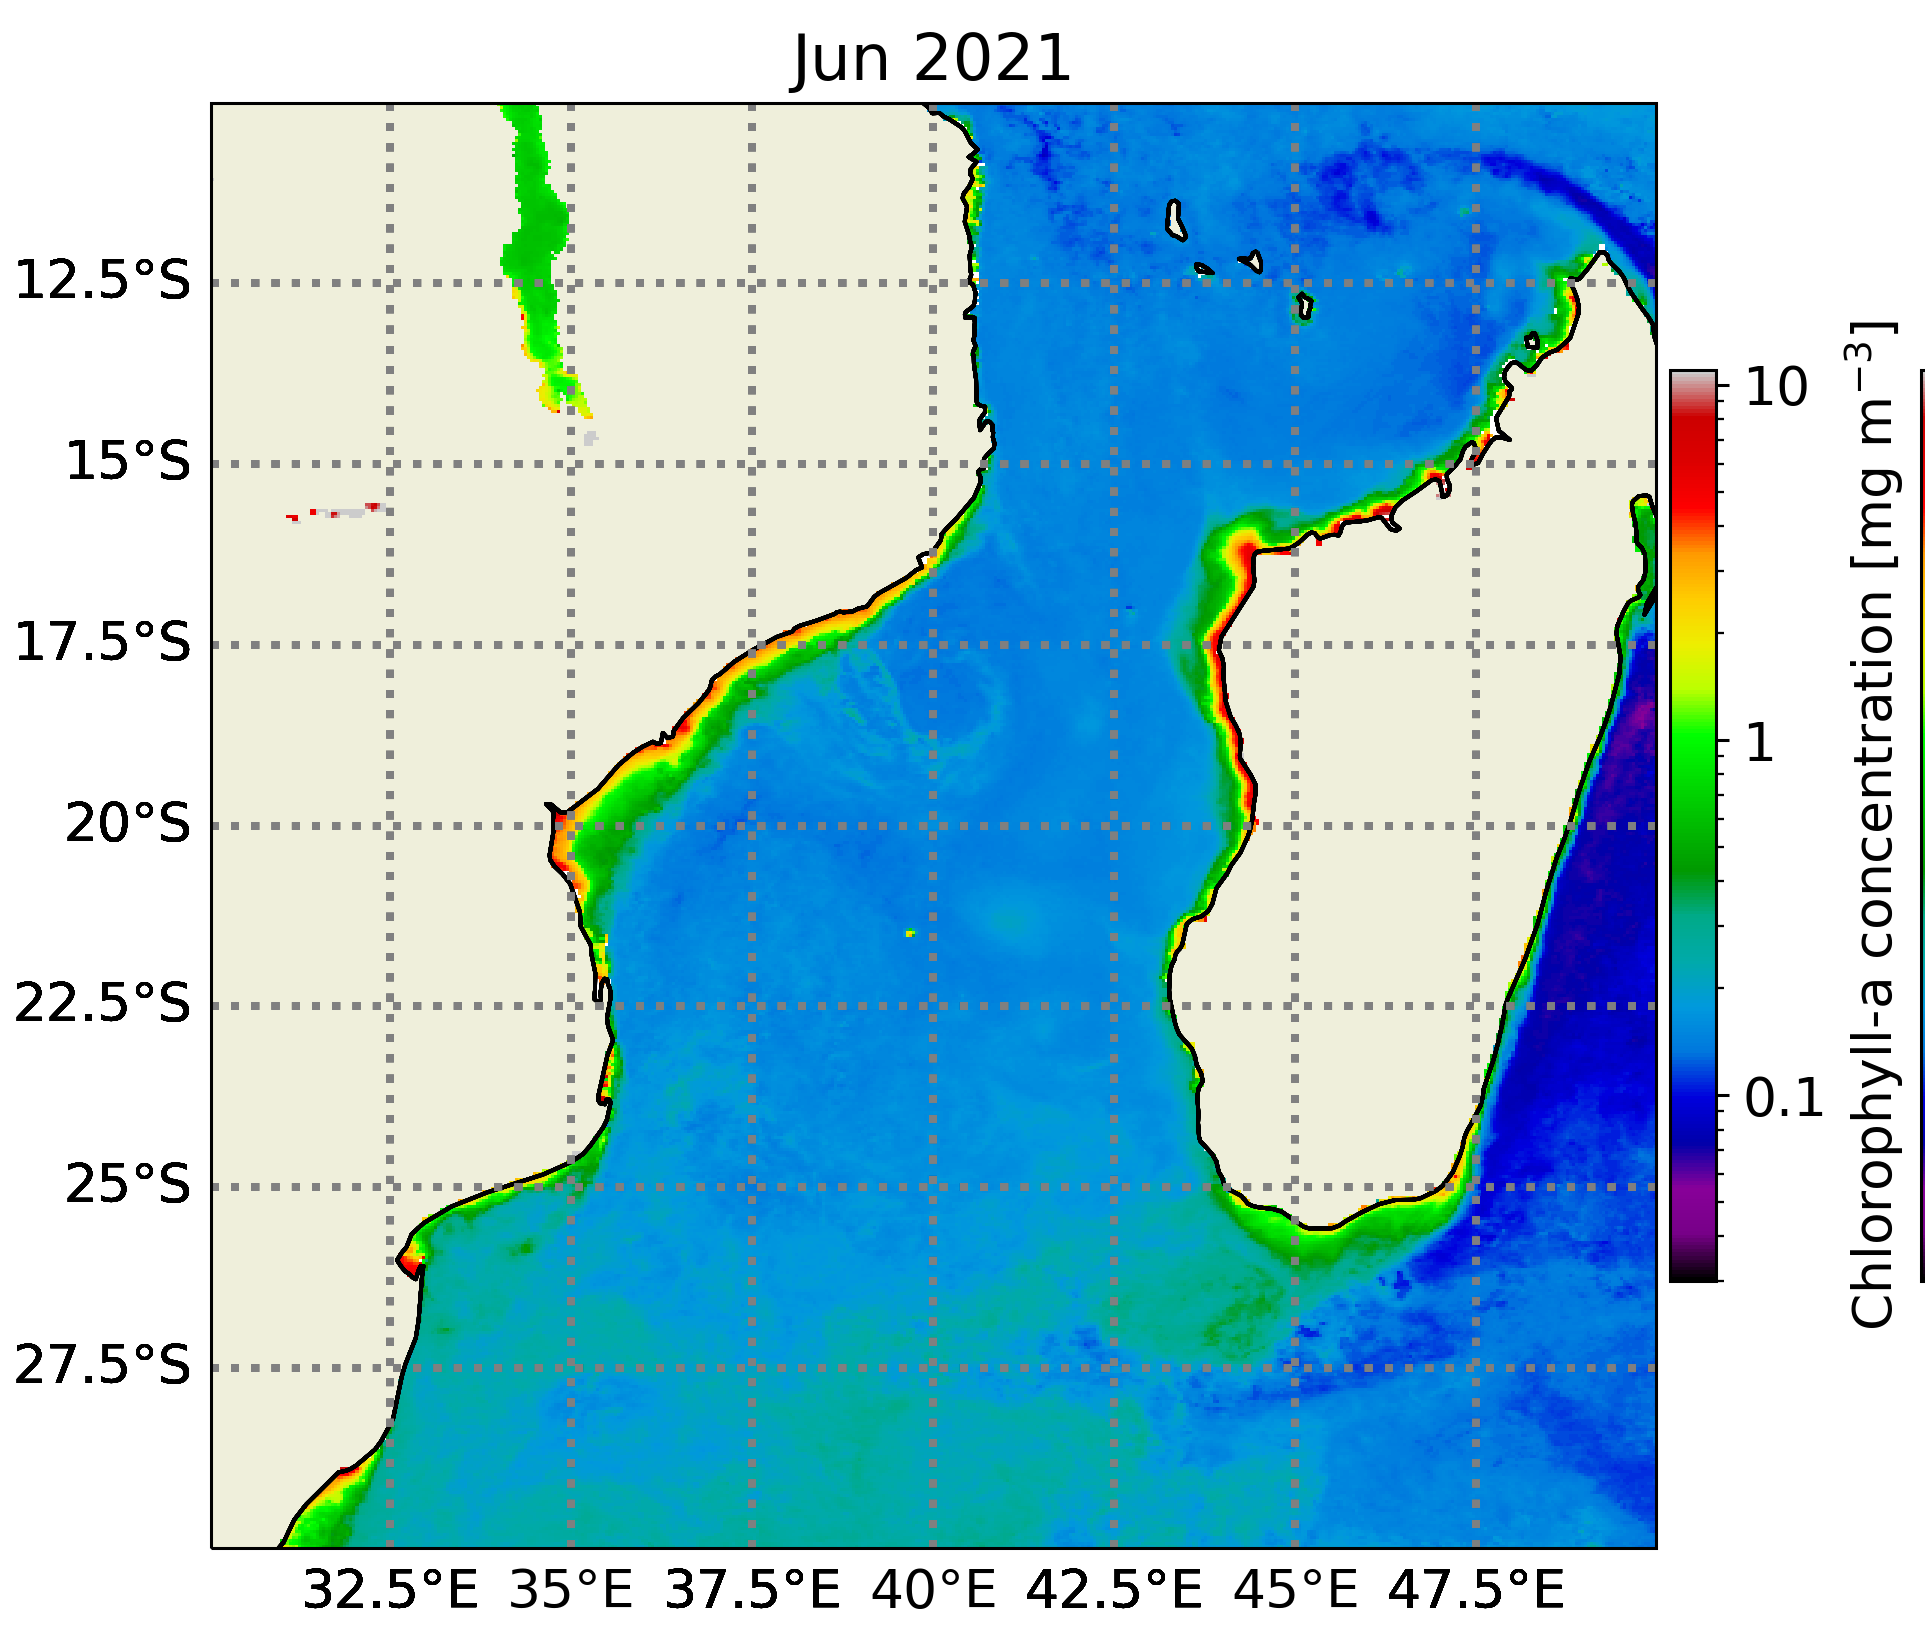

In [11]:
fig, ax = plt.subplots(subplot_kw={'projection': crs})

# blit=True: re-draw what has changed
# interval: Delay between frames in milliseconds.
anim = animation.FuncAnimation(fig, update_anime, 
                               init_func=init_anime,
                               frames=12,
                               interval=200, blit=True, repeat=True)
anim.save(cwd.joinpath('data', "A2021_MC_CHL_anime.gif"))

- Show animation using IPython notebook display HTML class.

In [12]:
HTML(anim.to_html5_video())

<div class="alert alert-block alert-success"/div>
    <h2>Done!</h2>
  
--- 

#### And thank you for your attention! :) 
    We hope you are enjoying the training provided by A-ECOP for A-ECOPs.

# 6. Resources

[Go back to the "Table of contents"](#Table-of-contents)

1. [IPython display](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#classes)
4. [Matplotlib animation](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html)
5. [Cartopy](https://scitools.org.uk/cartopy/docs/latest/#)
7. [ECOPs Ocean Colour Training](https://github.com/Elgyii/ocean-colour-training-ecops-africa)